In [1]:
# notebooks/model_random_forest.ipynb

In [18]:
# import libraries and helper fucntions 
import sys
import os

# add project root 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load target label
y_train = joblib.load('../outputs/models/y_train_tfidf_balanced.joblib')  # this just loads in the tfidf ones since these are all the same

# load the balanced datasets 
X_train_tfidf = joblib.load('../outputs/models/X_train_tfidf_balanced.joblib')
X_train_bow = joblib.load('../outputs/models/X_train_bow_balanced.joblib')
X_train_spacy = joblib.load('../outputs/models/X_train_spacy_balanced.joblib')

In [ ]:
# hyperparamaters for random forest 
n_estimators = 50
max_depth = 20
min_samples_leaf=5

In [ ]:
# train RF with slected embedding technique funttion
def train_random_forest(X_train, y_train, model_name):
    rf = RandomForestClassifier(oob_score=True, 
                                random_state=21, 
                                n_estimators=n_estimators,
                                max_depth=10,
                                min_samples_leaf=5)
    rf.fit(X_train, y_train)
    model_path = f'../outputs/models/{model_name}.joblib'
    joblib.dump(rf, model_path) # dump file to joblib 
    print(f'Model saved to {model_path}')

# Random Forest x TFIDF
print("Training Random Forest x TFIDF...")
train_random_forest(X_train_tfidf, y_train, 'Random_Forest_TFIDF')
print("Done!")

# Random Forest x BOW
print("Training Random Forest x BoW...")
train_random_forest(X_train_bow, y_train, 'Random_Forest_BOW')
print("Done!")

# Random Forest x spaCy
print("Training Random Forest x SpaCy...")
train_random_forest(X_train_spacy, y_train, 'Random_Forest_SPACY')
print("Done!")

Training Random Forest x TFIDF...


In [9]:
from sklearn.metrics import accuracy_score, log_loss

# Helper function to calculate test loss and accuracy
def calculate_test_metrics(model, X, y_true, embedding_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    accuracy = accuracy_score(y_true, y_pred)
    loss = log_loss(y_true, y_proba)
    print(f"Test Set ({embedding_name}) - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    return accuracy, loss

# Helper function to extract OOB metrics
def calculate_oob_metrics(model, embedding_name):
    if hasattr(model, "oob_score_"):
        oob_accuracy = model.oob_score_
        print(f"OOB ({embedding_name}) - Accuracy: {oob_accuracy:.4f}")
        return oob_accuracy
    else:
        print(f"OOB ({embedding_name}) - Not Available (ensure OOB is enabled during training)")
        return None

# Load the test data
X_test_tfidf = joblib.load('../outputs/models/X_test_tfidf.joblib')
y_test = joblib.load('../outputs/models/y_test.joblib')

X_test_bow = joblib.load('../outputs/models/X_test_bow.joblib')  # Assuming this exists for BoW
X_test_spacy = joblib.load('../outputs/models/X_test_spacy.joblib')  # Assuming this exists for spaCy

# Load the trained Random Forest models (ensure they were trained with `oob_score=True`)
rf_tfidf = joblib.load('../outputs/models/Random_Forest_TFIDF.joblib')
rf_bow = joblib.load('../outputs/models/Random_Forest_BOW.joblib')
rf_spacy = joblib.load('../outputs/models/Random_Forest_SPACY.joblib')

# Calculate OOB and test metrics for TFIDF, BoW, and SpaCy embeddings
oob_accuracies = []
test_accuracies = []
test_losses = []

for model, X_test, embedding_name in zip(
    [rf_tfidf, rf_bow, rf_spacy],
    [X_test_tfidf, X_test_bow, X_test_spacy],
    ["TFIDF", "BoW", "SpaCy"]
):
    # Calculate OOB accuracy
    oob_accuracy = calculate_oob_metrics(model, embedding_name)
    oob_accuracies.append(oob_accuracy)
    
    # Calculate test set metrics
    test_accuracy, test_loss = calculate_test_metrics(model, X_test, y_test, embedding_name)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

# Organize data for analysis or plotting
metrics_data = {
    'embeddings': ['TFIDF', 'BOW', 'SpaCy'],
    'oob_accuracies': oob_accuracies,
    'test_accuracies': test_accuracies,
    'test_losses': test_losses
}

# Print the final metrics for clarity
print("\nMetrics Summary:")
for i, embedding in enumerate(metrics_data['embeddings']):
    print(f"\nEmbedding: {embedding}")
    print(f"  OOB Accuracy: {metrics_data['oob_accuracies'][i]}")
    print(f"  Test Accuracy: {metrics_data['test_accuracies'][i]}")
    print(f"  Test Loss: {metrics_data['test_losses'][i]}")

print("\nMetrics saved successfully.")


OOB (TFIDF) - Accuracy: 0.8416
Test Set (TFIDF) - Accuracy: 0.5472, Loss: 1.1027
OOB (BoW) - Accuracy: 0.7465
Test Set (BoW) - Accuracy: 0.5384, Loss: 1.1438
OOB (SpaCy) - Accuracy: 0.8265
Test Set (SpaCy) - Accuracy: 0.5113, Loss: 1.1578

Metrics Summary:

Embedding: TFIDF
  OOB Accuracy: 0.8416402043352202
  Test Accuracy: 0.5472066357648206
  Test Loss: 1.102671641191409

Embedding: BOW
  OOB Accuracy: 0.7465414883335635
  Test Accuracy: 0.5384240058550867
  Test Loss: 1.1437657434812838

Embedding: SpaCy
  OOB Accuracy: 0.8264807400248516
  Test Accuracy: 0.5113442303000731
  Test Loss: 1.1578278515328393

Metrics saved successfully.


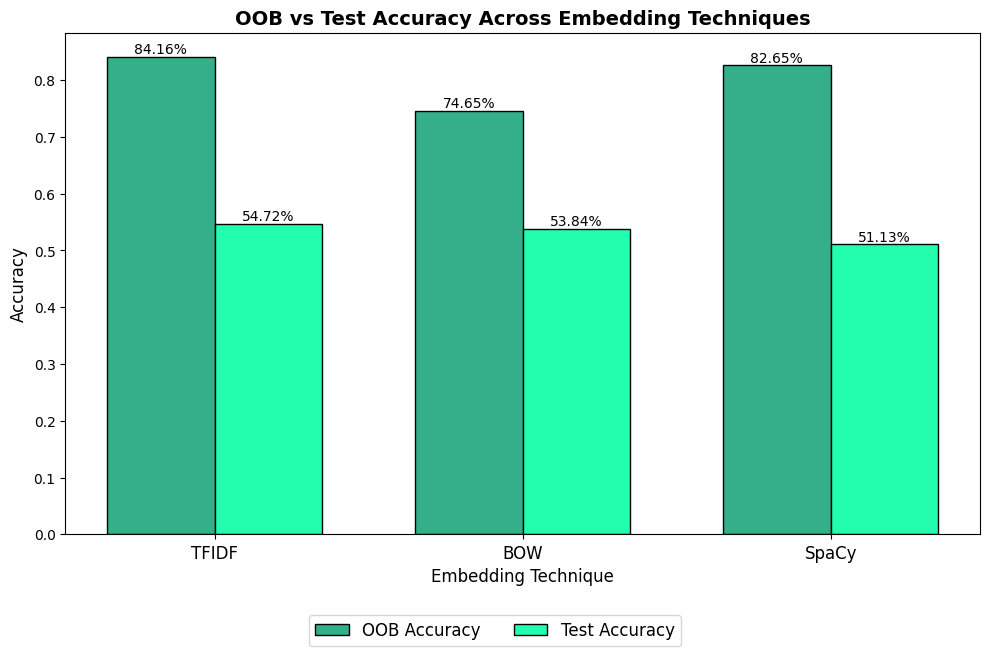

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Custom color palette
custom_palette = [
    '#1E4436',  # Dark green
    '#35AF8A',  # Mid green
    '#23FEAE',  # Bright green
]

# Data for OOB and Test Set metrics (already computed in metrics_data)
embeddings = metrics_data['embeddings']
oob_accuracies = metrics_data['oob_accuracies']  # OOB accuracies
test_accuracies = metrics_data['test_accuracies']  # Test accuracies

# Bar chart configurations
x = np.arange(len(embeddings))  # The label locations
width = 0.35  # Width of the bars

# Create a single subplot for Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting Accuracy Bar Chart
bars1 = ax.bar(x - width/2, oob_accuracies, width, label='OOB Accuracy', color=custom_palette[1], edgecolor='black')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color=custom_palette[2], edgecolor='black')
ax.set_xlabel('Embedding Technique', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(embeddings, fontsize=12)
ax.set_title('OOB vs Test Accuracy Across Embedding Techniques', fontsize=14, fontweight='bold')

# Add percentage labels on top of the bars for accuracy
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom', fontsize=10)

# Add legend below the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), fontsize=12)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Leave space for the legend below the plot
plt.show()


In [ ]:
import joblib

# Load balanced datasets for TFIDF
X_train_tfidf = joblib.load('../outputs/models/X_train_tfidf_balanced.joblib')
y_train_tfidf = joblib.load('../outputs/models/y_train_tfidf_balanced.joblib')

# Load balanced datasets for BOW
X_train_bow = joblib.load('../outputs/models/X_train_bow_balanced.joblib')
y_train_bow = joblib.load('../outputs/models/y_train_bow_balanced.joblib')

# Load balanced datasets for spaCy
X_train_spacy = joblib.load('../outputs/models/X_train_spacy_balanced.joblib')
y_train_spacy = joblib.load('../outputs/models/y_train_spacy_balanced.joblib')


from sklearn.ensemble import RandomForestClassifier

# Random Forest with TFIDF
rf_tfidf = RandomForestClassifier(random_state=21)
rf_tfidf.fit(X_train_tfidf, y_train_tfidf)
joblib.dump(rf_tfidf, '../outputs/models/Random_Forest_TFIDF.joblib')

# Random Forest with BOW
rf_bow = RandomForestClassifier(random_state=21)
rf_bow.fit(X_train_bow, y_train_bow)
joblib.dump(rf_bow, '../outputs/models/Random_Forest_BOW.joblib')

# Random Forest with spaCy
rf_spacy = RandomForestClassifier(random_state=21)
rf_spacy.fit(X_train_spacy, y_train_spacy)
joblib.dump(rf_spacy, '../outputs/models/Random_Forest_SPACY.joblib')